In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute, transpile, assemble, IBMQ
from qiskit.utils import QuantumInstance
from qiskit.circuit import Parameter,ParameterVector
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import EfficientSU2, ZZFeatureMap
from qiskit.opflow import Z, X, I, StateFn, CircuitStateFn, SummedOp
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI, Hessian
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.algorithms.classifiers import VQC
from sklearn.preprocessing import OneHotEncoder
from qiskit.providers.aer.noise import NoiseModel
from qiskit.algorithms.optimizers import SPSA, GradientDescent, QNSPSA, ADAM
from qiskit.tools.monitor import job_monitor

import numpy as np
import itertools as itr
import matplotlib.pyplot as plt
from qiskit_machine_learning.runtime import TorchRuntimeClient, TorchRuntimeResult

ACC_COUNT = 10

## Amp
DIR_val_train_amp = "Encode_data/amp_enc_data_set_trainning_values.csv"
DIR_cls_train_amp = "Encode_data/amp_enc_data_set_trainning_classes.csv"
DIR_val_test_amp = "Encode_data/amp_enc_data_set_test_values.csv"
DIR_cls_test_amp = "Encode_data/amp_enc_data_set_test_classes.csv"

## Ang
DIR_val_train_ang = "Encode_data/ang_enc_data_set_trainning_values.csv"
DIR_cls_train_ang = "Encode_data/ang_enc_data_set_trainning_classes.csv"
DIR_val_test_ang = "Encode_data/ang_enc_data_set_test_values.csv"
DIR_cls_test_ang = "Encode_data/ang_enc_data_set_test_classes.csv"\

provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_manila')
noise_model = NoiseModel.from_backend(backend)

quantum_instance = QuantumInstance(backend=Aer.get_backend('qasm_simulator'), 
                                   shots=1024,
                                   noise_model=noise_model)

In [2]:
n_qubits = 2

encoding = RawFeatureVector(n_qubits**2)

#2 Fica num platue de cost = 2
ansatz = EfficientSU2(n_qubits, entanglement='full', reps=4, 
                        insert_barriers=True, name="U(\u03B8)", 
                        parameter_prefix="\u03B8")

qc = encoding.compose(ansatz)
qc.measure_all()

In [3]:
def get_encode(file):
    """
     Funcao responsavel pelo encoding (amplitude)
        Input :: 
        ### file : File dir
        Output :: 
        #### data_enc : Valores para o encode (numpy array)
    """
    return np.genfromtxt(file, delimiter=";")

train_data_amp = get_encode(DIR_val_train_amp)
train_labels_amp = get_encode(DIR_cls_train_amp)

test_data_amp = get_encode(DIR_val_test_amp)
test_labels_amp = get_encode(DIR_cls_test_amp)

encoder = OneHotEncoder()
train_labels_oh_amp = encoder.fit_transform(train_labels_amp.reshape(-1, 1)).toarray()
test_labels_oh_amp = encoder.fit_transform(test_labels_amp.reshape(-1, 1)).toarray()

print("Training data set: ", len(train_labels_amp))
print("Testing data set:  ", len(test_labels_amp))

Training data set:  20
Testing data set:   6


In [4]:
def store_intermediate_result(evaluation, parameter, cost, 
                                stepsize, accept):
                evaluations.append(evaluation)
                parameters.append(parameter)
                costs.append(cost)

        # Set up the optimization

parameters = []
costs = []
evaluations = []
initial_point = np.random.random(ansatz.num_parameters)

vqc = VQC(feature_map=encoding,
          ansatz=ansatz,
          loss='cross_entropy',
          optimizer=SPSA(maxiter=5, callback=store_intermediate_result),
          initial_point=initial_point,
          quantum_instance=quantum_instance)

vqc.fit(train_data_amp, train_labels_oh_amp)

Cannot compute gradient operator! Continuing without gradients!


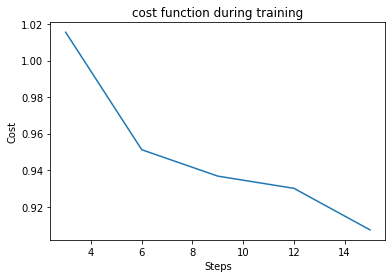

Labels:  [[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]
Predict:  [[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]
Score:  0.16666666666666666


In [5]:
fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.title("cost function during training")
plt.show()

print("Labels: ", test_labels_oh_amp)
print("Predict: ", vqc.predict(test_data_amp))
print("Score: ", vqc.score(test_data_amp, test_labels_oh_amp))

In [11]:
train_data_ang = get_encode(DIR_val_train_ang)
train_labels_ang = get_encode(DIR_cls_train_ang)

test_data_ang= get_encode(DIR_val_test_ang)
test_labels_ang = get_encode(DIR_cls_test_ang)

encoder = OneHotEncoder()
train_labels_oh_ang = encoder.fit_transform(train_labels_ang.reshape(-1, 1)).toarray()
test_labels_oh_ang = encoder.fit_transform(test_labels_ang.reshape(-1, 1)).toarray()

In [12]:
n_qubits = 5

encoding = ZZFeatureMap(feature_dimension=n_qubits, reps=3)

ansatz = EfficientSU2(n_qubits, entanglement='full', reps=3, 
                        insert_barriers=True, name="U(\u03B8)", 
                        parameter_prefix="\u03B8")

qc = encoding.compose(ansatz)
qc.measure_all()

In [13]:
def store_intermediate_result(evaluation, parameter, cost, 
                                stepsize, accept):
                evaluations.append(evaluation)
                parameters.append(parameter)
                costs.append(cost)

        # Set up the optimization

parameters = []
costs = []
evaluations = []
initial_point = np.random.random(ansatz.num_parameters)

vqc = VQC(feature_map=encoding,
          ansatz=ansatz,
          loss='cross_entropy',
          optimizer=SPSA(maxiter=1000, callback=store_intermediate_result),
          initial_point=initial_point,
          quantum_instance=Aer.get_backend('qasm_simulator'))

vqc.fit(train_data_ang, train_labels_oh_ang)

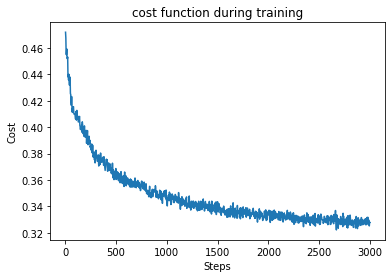

0.6666666666666666

In [14]:
fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.title("cost function during training")
plt.show()

print("Labels: ", test_labels_oh_ang)
print("Predict: ", vqc.predict(test_data_ang))
print("Score: ", vqc.score(test_data_amp, test_labels_oh_ang))